In [1]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter as savgol
from pathlib import Path
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
observed_stars = pd.read_csv("observedTESSnK2.csv", index_col = 0)

In [82]:
delta_sct = pd.DataFrame({'Name': ["Ascella", "Revati", "Porrima", "Zaniah", "kap Psc", "83 Aqr", "tet2 Tau", "ups Tau", "rho Tau", "HR 1427", "15 Ori", "97 Tau", "56 Tau", "80 Tau", "51 Tau", "89 Tau", "HR 1554", "HR 1385", "45 Cnc", "50 Cnc", "HR 5059", "49 Cnc"]})

In [83]:
#delta_sct = pd.DataFrame({'Name': ["Revati"]})

In [84]:
delta_sc_merged =observed_stars.merge(delta_sct, on='Name')[["Name", "EPIC ID"]]

In [85]:
delta_sc_merged

,Name,EPIC ID
0,Porrima,200084004
1,Zaniah,200084005
2,tet2 Tau,200173845
3,ups Tau,200173848
4,rho Tau,200173851
5,HR 1427,200173855
6,15 Ori,200173854
7,97 Tau,200173857
8,56 Tau,200173861
9,80 Tau,200173866


In [ ]:
for index, row in delta_sc_merged.iterrows():
    print(row["Name"], row["EPIC ID"], end='')
    
    name = row["Name"]
    epic_id = row["EPIC ID"]

    #download tess
    lc_search = lk.search_lightcurve(name,exptime=120)    
    lc = lc_search.download_all()
        
    lc[0] = lc[0].remove_nans().normalize()
    tess_time = lc[0].time.value
    tess_flux = lc[0].flux.value
    min_freq_tess = 1/10.
    max_freq_tess = 360.
    freqs_tess = np.logspace(np.log10(min_freq_tess),np.log10(max_freq_tess),100000) # tess from 10 day period to 360 c/d nyquist
    ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
    power_tess = ls_tess.power(freqs_tess)
    max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)
    
    tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,3)
    
    tess_tpf =  lk.search_targetpixelfile(name,exptime=120).download();
    
    #download halo
    
    halo_filename = Path('/Users/uqitroit/Dev/halo_vs_tess/Tess_light_curve/fits/hlsp_halo_k2_llc_%s_lc.fits' % epic_id)
    halo = Table.read(halo_filename)
    print('')
    
    m = np.isfinite(halo['corr_flux'])
    halo = halo[m]
    halo_flux = halo['flux']
    halo_time = halo['time']
    halo_corr_flux = halo['corr_flux']
    
    halo_normalized_flux = halo_corr_flux/np.nanmedian(halo_corr_flux)
    halo_trend = savgol(halo_corr_flux/np.nanmedian(halo_corr_flux),701,3)
    
    halo_lc = LombScargle(halo_time,halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
    freqs_halo = np.linspace((1/30.),24.,100000)
    power_halo = halo_lc.power(freqs_halo)
    max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)
    
    halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,100)
    
    fig = plt.figure(figsize=(12.0,9.0))
    plt.plot(freqs_tess, -power_tess, '-,' ,label="TESS")
    plt.plot(freqs_halo, power_halo,'-,' , label="K2")
    plt.legend(loc="upper right", )
    ylim_set = np.max((np.max(power_tess), np.max(power_halo).value))
    #plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
    #thruster fire harmonics
    #plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    #plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    #plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xlim(-12., 60)
    plt.ylim(-ylim_set, ylim_set)
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('TESS vs K2 periods')
    plt.grid(True)
    
    pp = PdfPages('dl_sc_freq/%s_%s.pdf' % (epic_id, name))
    pp.savefig(fig)
    pp.close()

Porrima 200084004
Zaniah 200084005
tet2 Tau 200173845
ups Tau 200173848
rho Tau 200173851
HR 1427 200173855
15 Ori 200173854
97 Tau 200173857
56 Tau 200173861
80 Tau 200173866
51 Tau 200173865
89 Tau 200173868
HR 1554 200173874
HR 1385 200173875
kap Psc 200164167
83 Aqr 200164168
Revati 200068393
45 Cnc 200200728
50 Cnc 200200363
HR 5059 200213058
49 Cnc 200233189

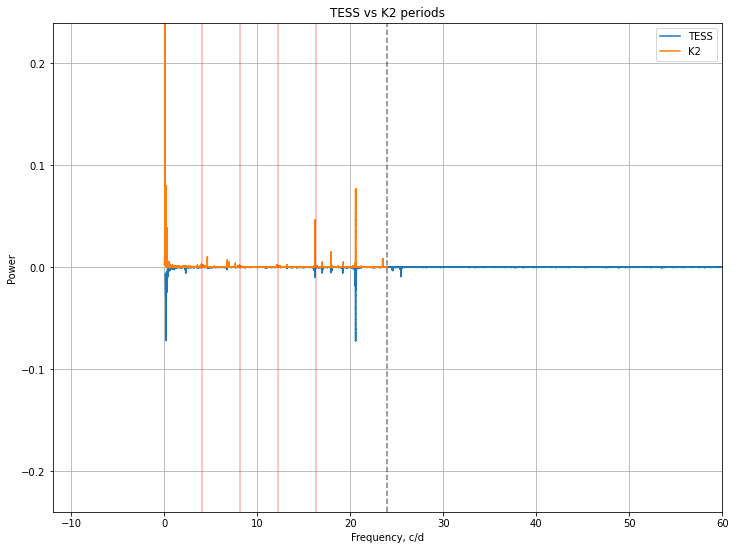

In [81]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(freqs_tess, -power_tess, '-,' ,label="TESS")
plt.plot(freqs_halo, power_halo,'-,' , label="K2")
plt.legend(loc="upper right", )
ylim_set = np.max((np.max(power_tess), np.max(power_halo).value))
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
#thruster fire harmonics
#plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xlim(-12., 60)
plt.ylim(-ylim_set, ylim_set)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('TESS vs K2 periods')
plt.grid(True)


In [58]:
np.max(power_tess)

0.46208285200716154

In [72]:
ylim = np.max((np.max(power_tess), np.max(power_halo).value))

In [73]:
ylim

0.46208285200716154

In [69]:
 np.max(power_halo).value

0.23183004511681196